En la siguiente celda, implemento dos funciones útiles para realizar algunos de los cálculo necesarios para el cálculo de la ENFICC como está determinado en la [Resolución CREG 071 de 2006](http://apolo.creg.gov.co/Publicac.nsf/1c09d18d2d5ffb5b05256eee00709c02/4f8f33924247ce4a0525785a007a6d74?OpenDocument).  

La función *ghi_mensual* calcula la energía total en $kWh/m^2$ para cada mes en la serie de datos. Con esta información, la función *ghi_dia* calcula el promedio diario de cada mes.

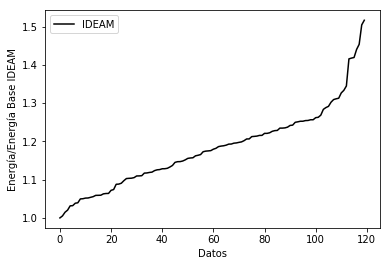

In [103]:
pylab.xlabel("Datos")
pylab.ylabel("Energía/Energía Base IDEAM") #la energía base es el promedio minimo producido
numdatos = range(len(datos_IDEAM))
pylab.plot(numdatos,datos_IDEAM/datos_IDEAM[0],'-k', label='IDEAM')
pylab.legend(loc='upper left')
pylab.savefig(os.path.join(output_dir,'valledupar_IDEAM.png'), dpi=600)

# Taller 1
## Diego Felipe Bryan \\ 201425625
### Teniendo en cuenta el código anterior quiero:
#### 1. Hacer una función o programa que haga el cálculo de la ENFICC.
#### 2. Función que devuelva la gráfica comparando la distribución de energía de diferentes series 
#### 3. Función para Medición-Correlación-Predicción que recibe IDEAM recortada, usa los datos de NREL y devuelve algo parecidoa IDEAM completa
#### 4. Funciones para calcular RMSEn, MBE, KSI% entre dos funciones y devuelve el error indicado.
#### 5. Análisis de eficacia para series de tiempo de diferentes localizaciones. Analizando como afecta la cantidad de datos y el año seleccionado.
#### 6. Es para el viernes 16 de Febrero de 2018 antes de las 5 pm.

## Función EINFICC 99%

In [32]:
import os #comandos operativos (se usa para unir las rutas)
import pandas as pd #se usa para manejar los datos -leer y crear-
#importa numpy  y matplotlib
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [6]:
base_dir = os.path.join( '.','data') #Dirección a la carpeta data -La carpeta debe estar creada-
output_dir = os.path.join( '.','output') #Dirección a la carpeta output -La carpeta debe estar creada-
ciudad = 'Valledupar' #nombre del lugar a evaluar
fuente = 'IDEAM'#origen de los datos, puede ser IDEAM o NREL
serie_csv = os.path.join(base_dir,ciudad,fuente+'.csv') #Dirección completa de los datos a evaluar
# Usa panda para leer la serie de datos
serie_pd = pd.read_csv(serie_csv, sep = ';', encoding='latin-1') # Toca saber cómo estan organizados los datos
fuenteSAT = 'NREL'
serie_csv_sat = os.path.join(base_dir,ciudad,fuenteSAT+'.csv')
sat = pd.read_csv(serie_csv_sat, sep = ';',encoding='latin-1')

In [7]:
def ghi_mensual(serie_horaria):
    agnos = sorted(serie_horaria['AÑO'].unique()) #.unique me elimina los datos repetidos
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"]) #Crea el dataframe para registrar los cálculos
    for agno in agnos:
        for mes in range(1,13):
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno)&(serie_horaria['MES'] == mes)]["DIA"].unique())
            #.loc me localiza la carpeta
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)& (serie_horaria["MES"] == mes)),nombre_energia].sum()/1000 
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],"GHImes":ghi_mes}
            #.append agrega los datos que acabo de crear
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df
def ghi_dia(serie_ghi_mensual):
    agnos = sorted(serie_ghi_mensual['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
    for agno in agnos:
        for mes in range(1,13):
            dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)&(serie_ghi_mensual["MES"] == mes)),"DIAS"].item()
            ghi_diario = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)& (serie_ghi_mensual["MES"] == mes)),"GHImes"].item()/dias
            ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df

In [14]:
def ENFICC (serie):
    mensual = ghi_mensual(serie)
    diario = ghi_dia(mensual)
    datos = sorted(diario["GHIdiario"]) #no me interesa en qué mes ocurre
    #solo interesa la distribución de los datos
    percentil = 0.01
    enficc = diario.quantile(q=percentil,numeric_only=True)["GHIdiario"]
    
    return print('La ENFICC 99% es: ', enficc)


In [81]:
mensual = ghi_mensual(serie_pd)
diario = ghi_dia(mensual)
datos_IDEAM = sorted(diario["GHIdiario"])

In [82]:
ENFICC(serie_pd)

La ENFICC 99% es:  4.56900737661


## Gráficas

In [83]:
def grafica1(serie1,str1):
    fig = figure()
    x = list(range(len(serie1)))
    y = serie1/serie1[-1]
    legend(loc='upper left')
    xlabel('Datos')
    ylabel('Energía / Energía Base IDEAM')
    fig = plot(x,y,'k-', label = str1 ) 
    pylab.legend(loc='upper left')
    pylab.savefig(os.path.join(output_dir,'prueba.png'), dpi=600)
    
    return fig
    

In [84]:
mensual = ghi_mensual(sat)
diario = ghi_dia(mensual)
datos_NREL = sorted(diario["GHIdiario"])

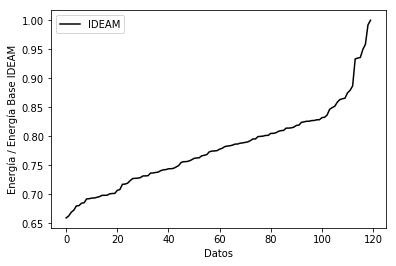

In [85]:
grafica1(datos,'IDEAM')

In [88]:
def grafica2(serie1,str1,serie2,str2):
    fig = figure()
    x1 = list(range(len(serie1)))
    y1 = serie1/serie1[-1]
    x2 = list(range(len(serie2)))
    y2 = serie2/serie2[-1]
    legend(loc='upper left')
    xlabel('Datos')
    ylabel('Energía / Energía Base IDEAM')
    fig = plot(x1,y1,'k-', x2, y2,'b-.', label = str1 : str2) 
    pylab.legend(loc='upper left')
    pylab.savefig(os.path.join(output_dir,'prueba.png'), dpi=600)
    
    return fig

SyntaxError: invalid syntax (<ipython-input-88-567572a559b8>, line 10)

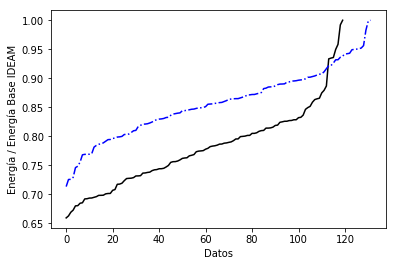

In [87]:
grafica2(datos_IDEAM,'IDEAM',datos_NREL, 'IDEAM2')

## MCP

In [122]:
corta = serie_pd[serie_pd['AÑO']==2010]


In [125]:
def MCP (objetivo,larga):
    correccion = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "HORA", "NRELvr"])
    objetivo_barra = objetivo['IDEAM'].sum()/len(objetivo)
    comun = larga[(larga['AÑO']>=objetivo.iloc[0,0])&(larga['AÑO']<=objetivo.iloc[-1,0])]
    comun_barra = comun['NREL'].sum()/len(comun)
    objetivo_sigma = objetivo['IDEAM'].std()
    comun_sigma = comun['NREL'].std()
    for i in range(0,len(larga)):
        ghi = objetivo_barra - (objetivo_sigma / comun_sigma)* comun_barra +  (objetivo_sigma / comun_sigma) * larga.iloc[i,4]
        if larga.iloc[i,4] == 0:
            ghi = 0
        ano = larga.iloc[i,0]
        mes = larga.iloc[i,1]
        dia = larga.iloc[i,2]
        hora = larga.iloc[i,3]
        cor = {"AÑO":ano, "MES":mes, "DIAS":dia, "HORA":hora, "NRELvr":ghi}
        correccion = correccion.append(cor, ignore_index=True)
    return correccion
    

In [126]:
corregida=MCP(corta,sat);

,AÑO,MES,DIAS,HORA,NRELvr
0,2005,1,1,0,0
1,2005,1,1,1,0
2,2005,1,1,2,0
3,2005,1,1,3,0
4,2005,1,1,4,0
5,2005,1,1,5,0
6,2005,1,1,6,4.76198
7,2005,1,1,7,153.921
8,2005,1,1,8,358.959
9,2005,1,1,9,544.17


## Cálculos de error

In [110]:
def MBE (serie1,serie2): #Donde la serie1 es la observada en tierra y la serie 2 es la modelada del satélite
    serie2 = serie2[(serie2['AÑO']>=serie1.iloc[0,0])]
    error = 0
    sumatoria = 0
    for i in range(0,len(serie1)):
        ghi_obs = serie1.iloc[i,4]
        ghi_mod = serie2.iloc[i,4]
        resta = ghi_obs - ghi_mod
        error = error + resta
        sumatoria = sumatoria + ghi_obs
        
    result = error / sumatoria 
    
    return print('El MBE es:',"{:.2%}".format(result))
   
        
        
    
    

In [111]:
MBE(serie_pd,sat)

El MBE es: -11.50%


In [29]:
def RMSE (serie1,serie2): #Donde la serie1 es la observada en tierra y la serie 2 es la modelada del satélite
    serie2 = serie2[(serie2['AÑO']>=serie1.iloc[0,0])&(serie2['AÑO']<=serie1.iloc[0,-1])]
    error = 0
    sumatoria = 0
    for i in range(0,len(serie1)):
        ghi_obs = serie1.iloc[i,4]
        ghi_mod = serie2.iloc[i,4]
        resta = (ghi_obs - ghi_mod)**2
        error = error + resta
        sumatoria = sumatoria + ghi_obs
        
    error = sqrt(error/len(serie1))
    result = error / (serie1['IDEAM'][serie1['IDEAM'].idxmax()]-serie1['IDEAM'][serie1['IDEAM'].idxmin()])  
    
    return print('El RMSE es:',"{:.2%}".format(result))
   


In [113]:
RMSE(serie_pd,sat)

El RMSE es: 9.07%


In [35]:
from scipy import stats

In [48]:
# Usar .stats.ks_2samp como KSI con tiempos equivalentes
def KSI (serie1, serie2):
    serie2 = serie2[(serie2['AÑO']>=serie1.iloc[0,0])&(serie2['AÑO']<=serie1.iloc[-1,0])]
    
    error = stats.ks_2samp(serie1['IDEAM'], serie2['NREL'])
    return print('El pvalue es:',error[-1])

    

In [50]:
KSI(serie_pd,sat)

El pvalue es: 2.4730515346e-59
